# Work To Do

1. load images
2. resiz images
3. def model
4. load mdel
5. def gram matrix
6. noramlize images
7. compute content loss, style loss
8. compute total loss and backward
9. save image(result)

In [50]:
%matplotlib inline

In [51]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils 
from torch.autograd import Variable

import copy

In [52]:
# Constants for the Image
CONTENT_IMG = "content.jpg"
STYLE_IMG = "style.jpg"

STEPS = 500;
MODEL = 'vgg19';

IMSIZE = 512 if torch.cuda.is_available() else 128

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

CNTWEIGHT = 1
STLWEIGHT = 1000

In [53]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)#kenel is the number of filter
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [54]:
# Function for the Image
    #1. pil->tensor
convert = transforms.Compose([
    transforms.Resize(IMSIZE),
    transforms.ToTensor()
])
'''이렇게만 하면, 같은 사이즈의 이미지만 처리할 수 있다. 
    더 확장하려면 mean 을 -,+ 과정을 거쳐야 함'''
    # 2. tensor -> pil
reconvert = transforms.ToPILImage()


#이미지 로드 함수
def imageLoad(image_name):
    img = Image.open(image_name)
    img = convert(img).unsqueeze(0)
    print("size:", img.size())
    return img.to(device, torch.float)

def showImage(tensor):
    image = tensor.cpu().clone() #not to change original image
    image = image.squeeze(0) #delete b  
    image = reconvert(image)
    plt.imshow(image) #image show

In [55]:
def gramMatrix(img):
    b, c, h, w = img.size() #batch size(1), chanel, height, width
    features = img.view(b*c, h*w) 
    gram = torch.mm(features, features.t())
    return gram
    #return G.div(a * b * c * d)
    #return F.div_(w*h)

In [56]:
def contentLoss(input, target):
    return F.mse_loss(content, target)

In [57]:
def styleLoss(input, target):
    target = gramMatrix(input)
    return F.mse_loss(content, target)

In [64]:
def makeOutput(vgg, input_img, style_losses, content_losses):
    num = 1
    while num <= STEPS:
        
        def closure():
            vgg(input_img)
            optimizer.zero_grad()
            style_total = 0
            content_total = 0
            for i in style_losses:
                style_total += i
            for i in content_losses:
                content_total += i
            style_total  = style_total * STLWEIGHT
            content_total = content_total * CNTWEIGHT
            total_loss = style_total + content_total 
            total_loss.backward()
            if num == 100:
                print("run {}:".format(num))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_total.item(), content_total.item()))
                print()
            return style_total + content_total
                
        optimizer.step(closure)
    return input_img    

size: torch.Size([1, 3, 128, 161])
size: torch.Size([1, 3, 128, 161])


RuntimeError: grad can be implicitly created only for scalar outputs

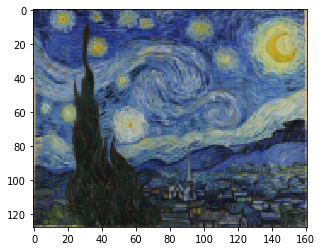

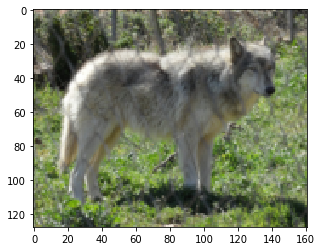

In [65]:
if __name__ == '__main__':
    
    #cuda load
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #images load
    content_img = imageLoad(CONTENT_IMG)
    style_img = imageLoad(STYLE_IMG)    
    plt.figure()
    showImage(style_img)
    plt.figure()
    showImage(content_img)
    
    #model load
    vgg = models.vgg19(pretrained=True).features.to(device)
    ##vgg = VGG()
    
    #normalize 
    normalization = nnormalize = transforms.Normalize(MEAN,STD)
    
    #initialize losses
    content_layers = [19]#cov4_1
    style_layers = [0, 5, 10, 19, 28]#conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    content_losses = [vgg(content_img) for i in content_layers]
    style_losses = [vgg(style_img) for i in style_layers]
    
    #compute total loss and make result image
    noise_img = torch.randn(content_img.data.size(), device=device)
    optimizer = optim.LBFGS([noise_img.requires_grad_()]); # LBFGS is a kind of alogorithms.it makes computation more easier
    result_img = makeOutput(vgg, noise_img, style_losses, content_losses)
    plt.figure()
    showImage(result_img)
    

    
    
    